In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import math
import os.path
from os import path
from scipy.signal import butter, filtfilt, lfilter
from scipy import fftpack
import warnings
import seaborn as sns
from tqdm import tqdm 

In [9]:
user_id = 'User04'
#raw_data_dir_path = os.path.join('../data/parsed_data', user_id)
parsed_data_dir_path = os.path.join('../data/parsed_data/', user_id)
figs_dir_path = os.path.join('./figs/', user_id)

# read data from csv file
all_data = pd.read_csv(os.path.join(parsed_data_dir_path, 'all_data.csv'))
all_gesture_name = all_data['Gesture'].unique()
print(all_gesture_name)

all_data['ang_x'] = all_data['ang_x'].apply(lambda x: np.sin(x * np.pi / 180))
all_data['ang_y'] = all_data['ang_y'].apply(lambda x: np.sin(x * np.pi / 180))
all_data['ang_z'] = all_data['ang_z'].apply(lambda x: np.sin(x * np.pi / 180))

# all_data['ang_x_v'] = all_data['ang_x'].diff()
# all_data['ang_y_v'] = all_data['ang_y'].diff()
# all_data['ang_z_v'] = all_data['ang_z'].diff()

# all_data['ang_x_a'] = all_data['ang_x_v'].diff()
# all_data['ang_y_a'] = all_data['ang_y_v'].diff()
# all_data['ang_z_a'] = all_data['ang_z_v'].diff()

foots = ['rightfoot', 'leftfoot', 'bothfoot']
directions = ['RecordingForth', 'RecordingBack']
trackers = ['FootL', 'FootR']

['NormalWalking' 'DraggingInFront' 'TapInward' 'SmallStep' 'LiftInFront'
 'ToeTapInFront' 'MidairRotationOutwards' 'KickOutward' 'KickInward'
 'TapWithHeel' 'TapOuward' 'BigStep' 'KickForward'
 'TapWithFootRotatedInwards' 'DraggingBehind' 'Delay' 'BendingBehind'
 'Rush' 'TapInFrontOfTheOtherFoot' 'TapWithFootRotatedOutwards'
 'ToeTapBehind' 'MidairRotationInwards' 'Click']


In [3]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    # print('b: ', b, 'a: ', a)
    y = lfilter(b, a, data)
    return y

In [4]:
def get_gesture_data(data, gesture_name, foot, direction):
    local_gesture_data = data[(data['Gesture'] == gesture_name)
                              & (data['Foot'] == foot) &
                              (data['Direction'] == direction)]

    # print('gesture_data shape: ', local_gesture_data.shape)

    checkpoint_list = local_gesture_data[local_gesture_data['Type'] ==
                                   'E']['Checkpoint'].tolist()

    checked_checkpoint_list = []
    for checkpoint in checkpoint_list:
        if checkpoint not in checked_checkpoint_list:
            if checkpoint_list.count(checkpoint) > 1:

                if type(checkpoint) == float:
                    candidates = local_gesture_data[
                        (local_gesture_data['Checkpoint'].isnull())
                        & (local_gesture_data['Type'] == 'E') &
                        (local_gesture_data['TrackerName'].isnull())]
                else:
                    candidates = local_gesture_data[
                        (local_gesture_data['Checkpoint'] == checkpoint)
                        & (local_gesture_data['Type'] == 'E') &
                        (local_gesture_data['TrackerName'].isnull())]

                # print(candidates['Time'])
                if candidates.size > 0:
                    start_time = candidates['Time'].iloc[0]
                    end_time = candidates['Time'].iloc[-1]
                    #print('checkpoint: ', checkpoint, 'start_time: ', start_time, 'end_time: ', end_time)

                    if type(checkpoint) == float:
                        local_gesture_data = local_gesture_data.drop(local_gesture_data[
                                                                         (local_gesture_data['Checkpoint'].isnull())
                                                                         & (local_gesture_data['Time'] >= start_time) &
                                                                         (local_gesture_data['Time'] < end_time)].index)
                    else:
                        local_gesture_data = local_gesture_data.drop(local_gesture_data[
                                                                         (local_gesture_data['Checkpoint'] == checkpoint)
                                                                         & (local_gesture_data['Time'] >= start_time) &
                                                                         (local_gesture_data['Time'] < end_time)].index)

                    # print('gesture_data shape: ', local_gesture_data.shape, 'gesture row sample ', local_gesture_data.iloc[0])
                    # update
                    checked_checkpoint_list.append(checkpoint)
                    # print("checked", checked_checkpoint_list)

    return local_gesture_data

In [5]:
def find_valleys(data, threshold):
    valleys = []
    data = np.array(data)

    for i in range(1, len(data) - 1):
        if data[i] < data[i - 1] and data[i] < data[i + 1] and data[i] < threshold:
            valleys.append(i)

    return valleys


def cut_step_data(tracker_data, gestureName, tracker_name, foot, direction):
    fs = 100
    order = 5

    # print('tracker_data shape: ', tracker_data.shape)

    tracker_data = tracker_data.copy()
    # tracker_data['pos_z_a'][2:] = butter_lowpass_filter(tracker_data['pos_z_a'][2:], 2, fs, order)

    # find the valleys
    # lowest_thresh = -0.5 / 100000

    # find the threshold
    # minimal = mean of the two lowest minima of the data
    minima = (np.diff(np.sign(np.diff(tracker_data['pos_z_a'][2:]))) > 0).nonzero()[0] + 1
    lowest_two_minima = tracker_data['pos_z_a'][2:].iloc[minima].nsmallest(5)
    minimal = lowest_two_minima.mean()


    average = tracker_data['pos_z_a'][2:].mean()
    threshold = (minimal + average) / 2.2

    valleys = find_valleys(tracker_data['pos_z_a'][2:], threshold)
    # valleys = find_mshape_valleys(tracker_data['pos_z_a'][2:])

    # cut the step data from the valleys
    all_steps = []
    for i in range(len(valleys) - 1):
        step = [valleys[i], valleys[i + 1]]
        all_steps.append(step)

    # print('steps amount: ', len(all_steps))
    # return the list of tracker data in each step

    all_steps_data = []
    for step in all_steps:
        step_data = tracker_data[step[0]:step[1]]
        all_steps_data.append(step_data)

    return all_steps_data

In [6]:
# for ploting the data with stride segmentation
for gesture in all_gesture_name[2:3]:
    if str(gesture) == 'nan':
        continue

    for foot in foots[:1]:
        for direction in directions[:1]:
            gesture_data = get_gesture_data(all_data, gesture, foot, direction)
            #print(gesture, foot, direction, gesture_data.shape)
            

            if gesture_data.shape[0] == 0:
                continue

            # get the tracker data
            for tracker_name in trackers[:]:
            # tracker_name = 'FootR'
                tracker_data = gesture_data[gesture_data['TrackerName'] == tracker_name]

                # if direction == 'RecordingBack', reverse pos_z, pos_x
                if direction == 'RecordingBack':
                    tracker_data['pos_z'] = -tracker_data['pos_z']
                    tracker_data['pos_x'] = -tracker_data['pos_x']


                for attr in ['pos_x', 'pos_y', 'pos_z', 'ang_x', 'ang_y', 'ang_z']:
                    warnings.simplefilter("ignore")
                    tracker_data[attr + '_v'] = tracker_data[attr].diff() / tracker_data['Time'].diff()
                    tracker_data[attr + '_a'] = tracker_data[attr + '_v'].diff() / tracker_data['Time'].diff()

                    tracker_data[attr + '_v'][1:] = butter_lowpass_filter(tracker_data[attr + '_v'][1:], 1, 100, 5)
                    tracker_data[attr + '_a'][2:] = butter_lowpass_filter(tracker_data[attr + '_a'][2:], 2, 100, 5)

                # get the step data
                warnings.simplefilter("ignore")
                all_steps_data = cut_step_data(tracker_data, gesture, tracker_name, foot, direction)

                # plot the all data in time series
                fig, ax = plt.subplots(1, 1, figsize=(20, 6))
                # title = direction, foot, gesture, tracker_name
                ax.set_title(gesture + '_' + foot + '_' + direction + '_' + tracker_name, fontsize=20)

                # plot pos_z_a, pos_y
                ax.plot(tracker_data['Time'], tracker_data['pos_z_a'] * 10000, color='blue', label='pos_z_a')
                ax.plot(tracker_data['Time'], tracker_data['pos_y'] , color='red', label='pos_y')
                ax.plot(tracker_data['Time'], tracker_data['pos_z_v'] * 100, color='green', label='pos_z_v')
                
                # plot pos_z_v, but with another tracker
                anoteher_tracker_name = 'FootL' if tracker_name == 'FootR' else 'FootR'
                other_tracker_data = gesture_data[gesture_data['TrackerName'] == anoteher_tracker_name]
                other_tracker_data['pos_z'] = -other_tracker_data['pos_z'] if direction == 'RecordingBack' else other_tracker_data['pos_z']
                other_tracker_data['pos_z_v'] = other_tracker_data['pos_z'].diff() / other_tracker_data['Time'].diff()
                other_tracker_data['pos_z_v'][1:] = butter_lowpass_filter(other_tracker_data['pos_z_v'][1:], 1, 100, 5)
                ax.plot(other_tracker_data['Time'], other_tracker_data['pos_z_v'] * 100, color='purple', label='pos_z_v (other)')

                ax.legend()

                checkpoints = gesture_data['Checkpoint'].unique()
                # print(checkpoints)
                for checkpoint in checkpoints[1:]:
                    checkpoint_data = gesture_data[gesture_data['Checkpoint'] == checkpoint]
                    ax.axvline(checkpoint_data['Time'].iloc[0], color='r', linestyle='--')
                    ax.axvline(checkpoint_data['Time'].iloc[0], color='r', linestyle='--')
                    ax.axvline(checkpoint_data['Time'].iloc[0], color='r', linestyle='--')

                # annotate the by steps
                for step_count, step_data in enumerate(all_steps_data):
                    ax.axvline(x=step_data['Time'].iloc[0], color='black', linestyle='--')
                    ax.axvline(x=step_data['Time'].iloc[-1], color='black', linestyle='--')
                    # ax.annotate('duration: ' + str(step_data['Time'].iloc[-1] - step_data['Time'].iloc[0]), xy=(step_data['Time'].iloc[0], 0), xytext=(step_data['Time'].iloc[0], 0), color='black')

                plt.show()

NameError: name 'all_gesture_name' is not defined

In [7]:
gesture_list = [
        "NormalWalking",
        "TapOuward",
        "TapInFrontOfTheOtherFoot",
        "TapInward",
        "BigStep", 
        "SmallStep",
        "ToeTapBehind",
        "ToeTapInFront",
        "TapWithHeel",
        "TapWithFootRotatedOutwards",
        "TapWithFootRotatedInwards",
        "Click",
        "KickInward",
        "KickOutward",
        "KickForward",
        "LiftInFront",
        "BendingBehind",
        "MidairRotationInwards",
        "MidairRotationOutwards",
        "DraggingInFront",
        "DraggingBehind",
        "Delay",
        "Rush"
    ]
duration_t1 = dict()
duration_t2 = dict()
duration_all = dict()
for i in gesture_list:
  duration_t1[i] = []
  duration_t2[i] = []
  duration_all[i] = []

In [10]:
for idx in range(2, 27):
   if idx < 10:
      user_id = 'User0' + str(idx)
   else:
      user_id = 'User' + str(idx)
   print(user_id)
   #raw_data_dir_path = os.path.join('../data/parsed_data', user_id)
   parsed_data_dir_path = os.path.join('../data/parsed_data/', user_id)
   figs_dir_path = os.path.join('./figs/', user_id)

   # read data from csv file
   all_data = pd.read_csv(os.path.join(parsed_data_dir_path, 'all_data.csv'))
   all_gesture_name = all_data['Gesture'].unique()

   # for ploting the data with stride segmentation
   for gesture in tqdm(all_gesture_name):
      if str(gesture) == 'nan':
         continue
      t_1, t_2, t_all, count = 0, 0, 0, 0
      for foot in foots[:]:
         for direction in directions[:]:
            gesture_data = get_gesture_data(all_data, gesture, foot, direction)
            if len(gesture_data) == 0: continue
            # print(gesture, foot, direction, gesture_data.shape)
            s, m1, m2, e = 0, 0, 0, 0
            #print(gesture_data[gesture_data["Type"] == "E"])
            event = gesture_data[gesture_data["Type"] == "E"]
            #print (event.iloc[2]["Time"])
            for i in range(len(event)):
               #print(event.iloc[i])
               if event.iloc[i]["Checkpoint"] == "StartPoint":
                  s = int(event.iloc[i]["Time"])
               if event.iloc[i]["Checkpoint"] == "MiddlePoint1":
                  m1 = int(event.iloc[i]["Time"])
               if event.iloc[i]["Checkpoint"] == "MiddlePoint2":
                  m2 = int(event.iloc[i]["Time"])
               if event.iloc[i]["Checkpoint"] == "EndPoint":
                  e = int(event.iloc[i]["Time"])
               #print(s, e, abs(s - e))

               if -1 in [s, m1, m2, e]:
                  continue
            if s == 0:
               if (direction == "RecordingForth"): 
                  s = gesture_data.iloc[0]["Time"] 
               else:
                  s = gesture_data.iloc[-1]["Time"]
            if e == 0:
               if (direction == "RecordingForth"): 
                  e = gesture_data.iloc[-1]["Time"] 
               else:
                  e = gesture_data.iloc[0]["Time"]
                  
            #print(foot + direction, s, m1, m2, e)
            if(direction == "RecordingForth"):
               t_1 += m2 - m1
               t_2 += e - m2
               t_all += e - s
               # if (abs(m2 - m1) > 10000 or abs(e - m2) > 10000 or abs(e - s) > 10000):
               #    print(gesture, foot, direction, s, m1, m2, e)
               count += 1
            else:
               t_1 += m1 - m2
               t_2 += s - m1
               t_all += s - e
               # if (abs(m1 - m2) > 10000 or abs(s - m1) > 10000 or abs(s - e) > 10000):
               #    print(gesture, foot, direction, s, m1, m2, e)
               count += 1
            #print(t1, t2, all)
            #if(gesture_name == "Rush"):
            #    print(1, gesture_name, foot, direction, t1, t2, all, int(all_data.iloc[s]["Time"]), int(all_data.iloc[m1]["Time"]), int(all_data.iloc[m2]["Time"]), int(all_data.iloc[e]["Time"]))
      duration_t1[gesture].append(t_1 / count / 1000)
      duration_t2[gesture].append(t_2 / count / 1000)
      duration_all[gesture].append(t_all / count / 1000)


User02


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


User03


100%|██████████| 23/23 [00:33<00:00,  1.46s/it]


User04


100%|██████████| 23/23 [00:26<00:00,  1.16s/it]


User05


100%|██████████| 23/23 [00:22<00:00,  1.04it/s]


User06


100%|██████████| 23/23 [00:20<00:00,  1.10it/s]


User07


100%|██████████| 23/23 [00:18<00:00,  1.24it/s]


User08


100%|██████████| 23/23 [00:18<00:00,  1.23it/s]


User09


100%|██████████| 23/23 [00:14<00:00,  1.60it/s]


User10


100%|██████████| 23/23 [00:20<00:00,  1.13it/s]


User11


100%|██████████| 23/23 [00:16<00:00,  1.41it/s]


User12


100%|██████████| 23/23 [00:12<00:00,  1.80it/s]


User13


C:\Users\kevin\AppData\Local\Temp\ipykernel_41252\1959517281.py:12: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(os.path.join(parsed_data_dir_path, 'all_data.csv'))
100%|██████████| 23/23 [00:19<00:00,  1.20it/s]


User14


100%|██████████| 23/23 [00:17<00:00,  1.33it/s]


User15


100%|██████████| 23/23 [00:16<00:00,  1.37it/s]


User16


100%|██████████| 23/23 [00:12<00:00,  1.90it/s]


User17


100%|██████████| 23/23 [00:17<00:00,  1.32it/s]


User18


100%|██████████| 23/23 [00:12<00:00,  1.88it/s]


User19


100%|██████████| 23/23 [00:16<00:00,  1.38it/s]


User20


100%|██████████| 23/23 [00:14<00:00,  1.60it/s]


User21


100%|██████████| 23/23 [00:14<00:00,  1.57it/s]


User22


100%|██████████| 23/23 [00:11<00:00,  1.93it/s]


User23


100%|██████████| 23/23 [00:11<00:00,  1.95it/s]


User24


100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


User25


100%|██████████| 23/23 [00:12<00:00,  1.81it/s]


User26


100%|██████████| 23/23 [00:11<00:00,  2.01it/s]


In [11]:
# drop data in duration_all that is bigger than 20s or smaller than 0.3
for dur_list in [duration_t1, duration_t2, duration_all]:
   for gesture in dur_list:
      for i in range(len(dur_list[gesture])):
         if i >= len(dur_list[gesture]):
            break
         if dur_list[gesture][i] > 20 or dur_list[gesture][i] < 0.3:
            print(dur_list[gesture][i])
            del dur_list[gesture][i]
            # duration_all[gesture].remove(duration_all[gesture][i])

0.08225
-0.03775
837983323.17375
0.20475
-666.92625
-3.08475
0.05525
-0.00025
-661.24525


In [12]:
# reverse the order of duration lists
from collections import OrderedDict
duration_t1 = OrderedDict(reversed(list(duration_t1.items())))
duration_t2 = OrderedDict(reversed(list(duration_t2.items())))
duration_all = OrderedDict(reversed(list(duration_all.items())))

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


(b) Trial 1 Duration (s)
(c) Trial 2 Duration (s)


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


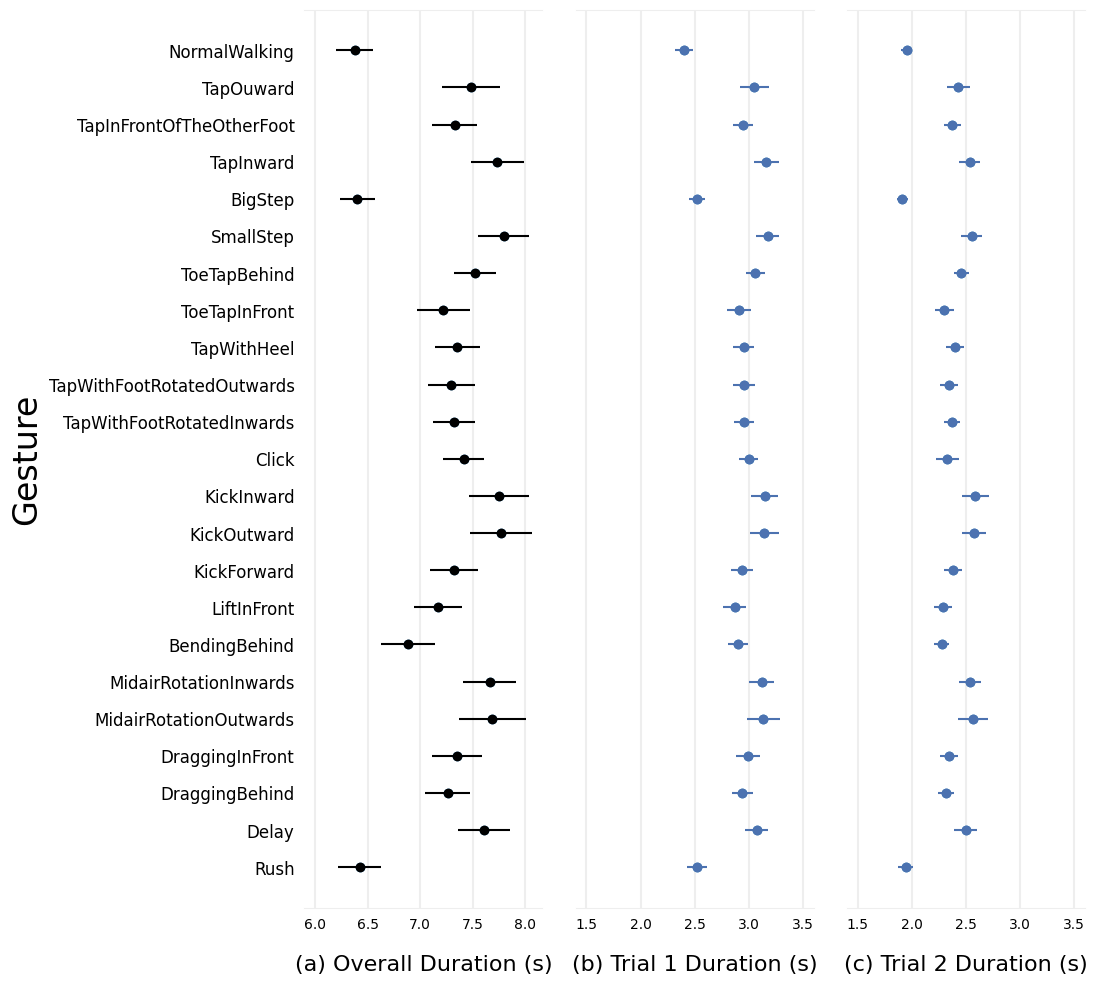

In [14]:
import matplotlib.pyplot as plt

def subplot_subjective_score(names, scores, error, datacolor, subtitle, pole_min, pole_max, xrange, ax, isleftmost):
    hfont = {'fontname':'Helvetica'}
    for i in xrange:
      ax.axvline(x=i, color='#EEEEEE', zorder=0)
    
    # setting xticks to be by integer 
    ax.set_xticks(xrange)

    #ax.set_xticklabels(names)

    #ax.set_xlim([0.5, 7.5])
  
    # setting margin between yticks

    #ax.yaxis.set_tick_params(labelsize=20)
    if isleftmost:
      ax.set_yticks(range(len(names)))
      ax.set_yticklabels(names, size = 12)
      ax.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=True, labelbottom=True)
    else: 
      print(subtitle)
      ax.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=True)
    # plt.ylabel("X-axis", labelpad=0)
    # Control the scale and distance of the y-ticks
    plt.gca().yaxis.set_tick_params(length=0, width=0, direction='out')
    #plt.gca().xaxis.set_tick_params(length=0, width=0, direction='out')

    ax.errorbar(scores, range(len(names)), xerr=error, fmt='o', color=datacolor)
    ax.scatter(scores, range(len(names)))
    # remove left and right border of plot
    ax.spines['right'].set_visible(False)

    ax.spines['left'].set_visible(False)

    # set top and bottom border color of plot to grey
    ax.spines['top'].set_color('#EEEEEE')
    ax.spines['bottom'].set_color('#EEEEEE')
    #ax.text(7, 23.5, pole_max, size = 8, ha = 'center')
    #ax.text(1, 23.5, pole_min, size = 8, ha = 'center')
    ax.set_xlabel(subtitle, labelpad=16, size = 16, **hfont)
    if isleftmost:
      ax.set_ylabel("Gesture", size = 24)
    # ax.set_title("Error Rate vs. Score")
    # plt.colorbar()
    plt.rcParams['figure.figsize'] = [8, 9]

fig, ax = plt.subplots(1, 3)
fig.tight_layout(pad = -1)
subplot_subjective_score(names = duration_all.keys(), 
                      scores = [sum(duration_all[i]) / len(duration_all[i]) for i in duration_all], 
                      error = [np.std(duration_all[i]) / np.sqrt(len(duration_all[i])) for i in duration_all],
                      datacolor = "black", subtitle = "(a) Overall Duration (s)", pole_min = "", pole_max = "", xrange = np.arange(6, 8.1, 0.5), ax = ax[0], isleftmost = True)
subplot_subjective_score(names = duration_t1.keys(), 
                      scores = [sum(duration_t1[i]) / len(duration_t1[i]) for i in duration_t1], 
                      error = [np.std(duration_t1[i]) / np.sqrt(len(duration_t1[i])) for i in duration_t1],
                      datacolor = "#4c72b0", subtitle = "(b) Trial 1 Duration (s)", pole_min = "", pole_max = "", xrange = np.arange(1.5, 4, 0.5), ax = ax[1], isleftmost = False)
subplot_subjective_score(names = duration_t2.keys(), 
                      scores = [sum(duration_t2[i]) / len(duration_t2[i]) for i in duration_t2], 
                      error = [np.std(duration_t2[i]) / np.sqrt(len(duration_t2[i])) for i in duration_t2],
                      datacolor = "#4c72b0", subtitle = "(c) Trial 2 Duration (s)", pole_min = "", pole_max = "", xrange = np.arange(1.5, 4, 0.5), ax = ax[2], isleftmost = False)

#plt.figure(facecolor='white')
#plt.show()
plt.savefig("Duration.png", bbox_inches="tight", transparent=True)

{'NormalWalking': [5.027,
  6.7585,
  6.413,
  6.313,
  6.6055,
  5.5695,
  6.3625,
  6.153,
  6.636,
  5.7095,
  8.6075,
  5.993,
  6.442,
  7.3135,
  5.3815,
  7.9575,
  6.4315,
  7.391,
  5.875,
  6.591,
  5.659,
  5.151,
  5.5315,
  5.7485,
  7.81875],
 'Delay': [5.73475,
  8.47625,
  8.4355,
  7.412,
  7.1285,
  6.82225,
  7.83025,
  6.023,
  9.42575,
  7.64425,
  8.04675,
  10.09825,
  8.06625,
  8.56725,
  5.74425,
  9.958,
  7.13925,
  9.21575,
  8.3635,
  7.657,
  6.348,
  6.73225,
  6.24675,
  6.40925,
  6.73275],
 'TapWithHeel': [6.15625,
  7.5355,
  9.22475,
  7.4435,
  7.111,
  6.165,
  6.10475,
  5.90025,
  7.752,
  7.52975,
  7.39725,
  8.472,
  8.21625,
  9.54025,
  6.3455,
  9.30425,
  6.545,
  8.99925,
  7.43325,
  7.17175,
  7.258,
  7.0525,
  6.6135,
  6.115,
  6.417],
 'TapWithFootRotatedInwards': [5.76725,
  8.057,
  9.1995,
  7.24375,
  7.45225,
  6.4515,
  6.932,
  6.0315,
  8.51575,
  7.98,
  8.0355,
  8.2,
  7.45575,
  7.9825,
  5.8415,
  9.097,
  6.804,
  8.1